Import the basic ML libraries:

In [102]:
import numpy as np
import pandas as pd
from seaborn import heatmap
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from math import floor

import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr

Read in the data from the 3 remaining datasets, get a basic idea of its properties. In particular, check to see how much of the data is unique.

In [66]:
first = pd.read_csv("./heart.csv")
second = pd.read_csv("./heart1.csv")
third = pd.read_csv("./heart2.csv")
print("shapes:")
print("first df ==", first.shape)
print("second df ==", second.shape)
print("third df == ", third.shape)

second = second.rename(columns={"trtbps" : "trestbps", "thalachh": "thalach", "exng": "exang", "slp" : "slope", "caa" : "ca", "thall": "thal", "output": "target"})

merged = second.merge(third)

print("second and third merged ==", merged.shape)

shapes:
first df == (918, 12)
second df == (303, 14)
third df ==  (1025, 14)
second and third merged == (1033, 14)


Clean and get all features and all classification labels for heart.csv as numpy arrs; split data for training and testing

In [67]:
feature_cols = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

X_df = first.loc[:, feature_cols]
X_df['Sex'].replace({'M':0, 'F':1}, inplace=True)
X_df = pd.get_dummies(X_df)

feature_cols_clean = list(X_df.columns)

X = X_df.to_numpy()

y_df = first.HeartDisease
y = y_df.to_numpy()

data_df = X_df.join(y_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Create a function to plot ROC and Precision/Recall curves

In [105]:
def plot_curves (name, clf): 
    probas_predict = clf.predict_proba(X_test)
    probas_predict = np.delete(probas_predict, 0, 1)
    prec, rec, thresh = precision_recall_curve(y_true=y_test, probas_pred= probas_predict)

    plt.plot(prec, rec)
    plt.title( name + " Precision-Recall Curve")
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.figure()

    fpr, tpr, thresh = roc_curve(y_test, probas_predict)
    auc_value = roc_auc_score(y_test, probas_predict)
    auc_string = "AUC = {:.2f}".format(auc_value)

    plt.plot(fpr, tpr)
    plt.title( name + " ROC Curve")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.text(0,1, auc_string)

Use Seaborn heatmap to show correlation of data in a grid

<AxesSubplot:>

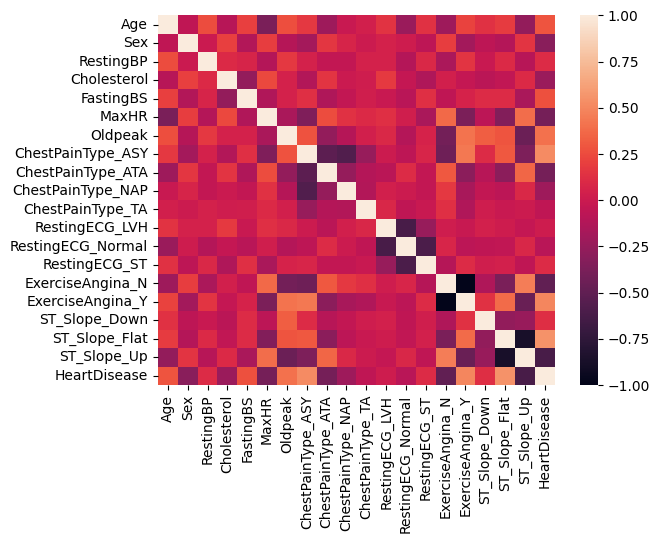

In [68]:
heatmap(data_df.corr())

k-nearest neighbors classification for heart.csv; find best k value via k-fold cross-validation

Best k = 41
Best KNN accuracy score = 0.7086956521739131
[[65 27]
 [40 98]]


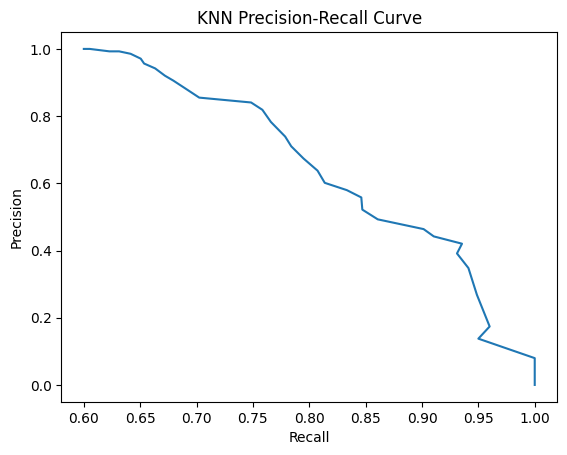

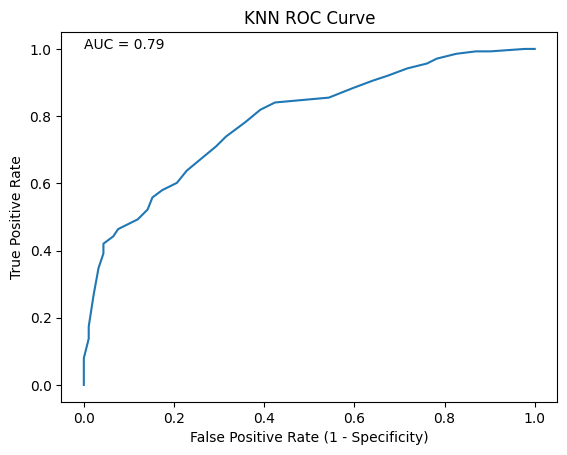

In [106]:
# Test k=1 to k=100
best_knn_avg_acc = 0
best_k = 0
for k in range(1,101):
    
    # Do k-fold cross-validation
    k_fold = KFold(n_splits=5)
    knn_avg_acc = 0
    knn_i = 0
    for train_i, valid_i in k_fold.split(X_train):
        
        # Do train and validation split
        X_train_train, X_valid = X_train[train_i], X_train[valid_i]
        y_train_train, y_valid = y_train[train_i], y_train[valid_i]
    
        # Fit the KNN model and get its accuracy score
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_train,y_train_train)
        knn_acc = accuracy_score(y_valid, knn.predict(X_valid))
        
        # Iteratively calculate the mean average accuracy score for the current k value
        knn_i += 1
        knn_avg_acc = knn_avg_acc + (1/knn_i) * (knn_acc - knn_avg_acc)
        
    # Keep track of the best k and its average accuracy score
    if knn_avg_acc > best_knn_avg_acc:
        best_knn_avg_acc = knn_avg_acc
        best_k = k
        
# Use the best found k value for KNN model using all training data
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Use test data to determine model performance as confusion matrix and accuracy score
best_knn_conf = confusion_matrix(y_test, best_knn.predict(X_test))
best_knn_acc = accuracy_score(y_test, best_knn.predict(X_test))

# Print out results
print("Best k = " + str(best_k))
print("Best KNN accuracy score = " + str(best_knn_acc))
print(best_knn_conf)

#plot Precision/Recall and ROC curves
plot_curves("KNN", best_knn)

SVM classification for heart.csv; evaluate performance via test data

SVM accuracy score = 0.8347826086956521
[[ 69  23]
 [ 15 123]]


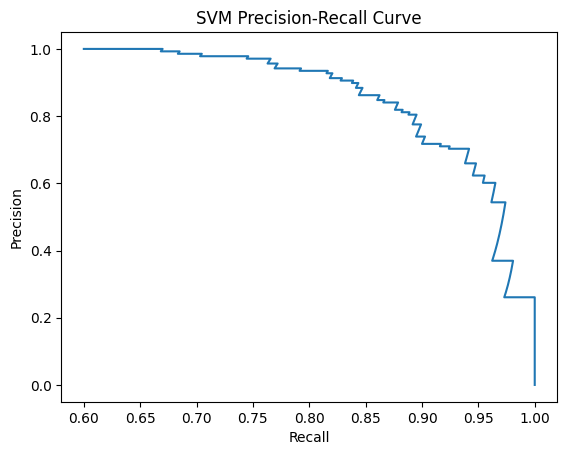

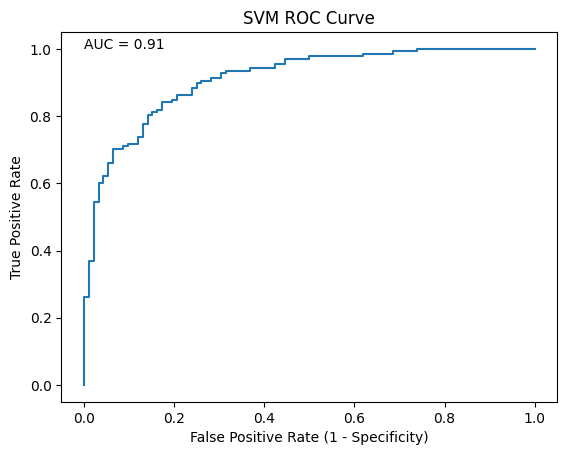

In [109]:
# Train SVM on training data
heart_svm = svm.SVC(kernel='linear', probability=True)
heart_svm.fit(X_train, y_train)

# Use test data to determine model performance as confusion matrix and accuracy score
svm_conf = confusion_matrix(y_test, heart_svm.predict(X_test))
svm_acc = accuracy_score(y_test, heart_svm.predict(X_test))

# Print out results
print("SVM accuracy score = " + str(svm_acc))
print(svm_conf)

#plot Precision/Recall and ROC curves
plot_curves("SVM", heart_svm)

Gaussian Naive Bayes classification for heart.csv; evaluate performance via test data

GNB accuracy score = 0.8347826086956521
[[ 70  22]
 [ 16 122]]


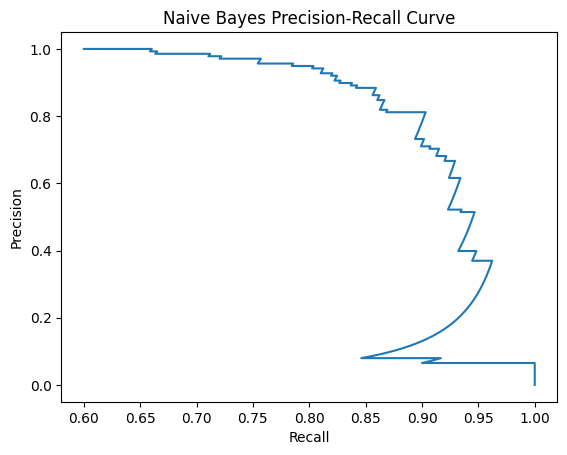

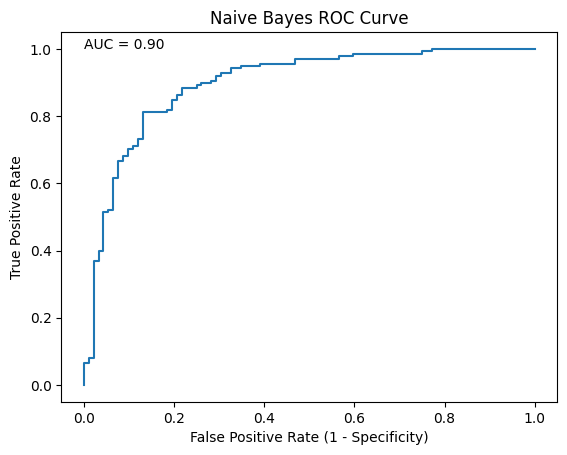

In [108]:
# Train Bayesian model on training data
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Use test data to determine model performance as confusion matrix and accuracy score
gnb_conf = confusion_matrix(y_test, gnb.predict(X_test))
gnb_acc = accuracy_score(y_test, gnb.predict(X_test))

# Print out results
print("GNB accuracy score = " + str(gnb_acc))
print(gnb_conf)

#plot Precision/Recall and ROC curves
plot_curves("Naive Bayes", gnb)

Random Forest classification for heart.csv; evaluate performance via test data

Random Forest accuracy score = 0.8478260869565217
[[ 72  20]
 [ 15 123]]


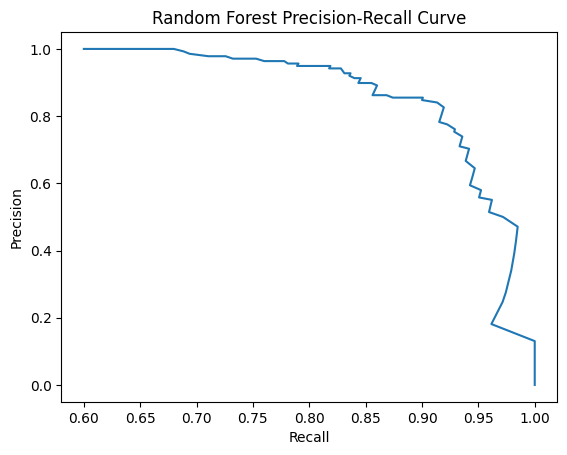

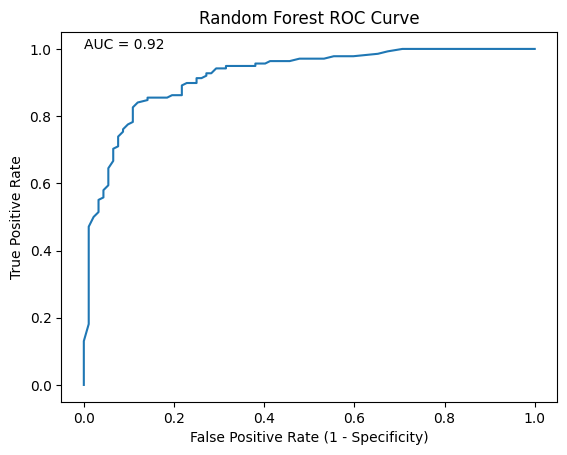

In [110]:
# Train Random Forest model on training data
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Use test data to determine model performance as confusion matrix and accuracy score
rf_conf = confusion_matrix(y_test, rf.predict(X_test))
rf_acc = accuracy_score(y_test, rf.predict(X_test))

# Print out results
print("Random Forest accuracy score = " + str(rf_acc))
print(rf_conf)

#plot Precision/Recall and ROC curves
plot_curves("Random Forest", rf)

AdaBoost classification for heart.csv; evaluate performance via test data

AdaBoost accuracy score = 0.8608695652173913
[[ 72  20]
 [ 12 126]]


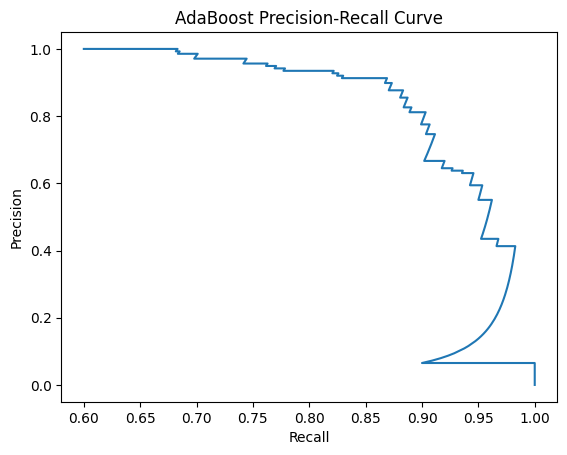

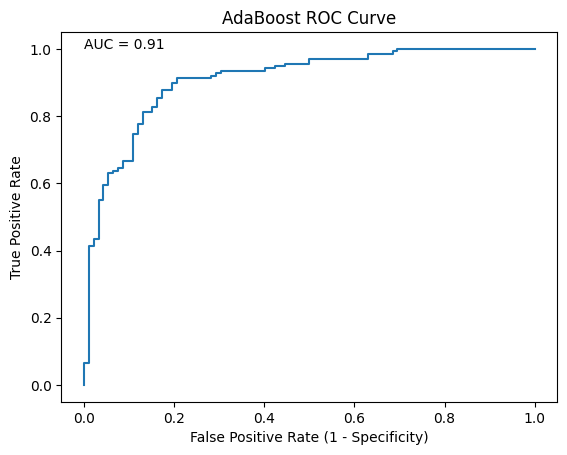

In [111]:
# Train AdaBoost model on training data
ab = AdaBoostClassifier(random_state=0)
ab.fit(X_train, y_train)

# Use test data to determine model performance as confusion matrix and accuracy score
ab_conf = confusion_matrix(y_test, ab.predict(X_test))
ab_acc = accuracy_score(y_test, ab.predict(X_test))

# Print out results
print("AdaBoost accuracy score = " + str(ab_acc))
print(ab_conf)

#plot Precision/Recall and ROC curves
plot_curves("AdaBoost", ab)

Multi-layer Perceptron (MLP) classification for heart.csv; evaluate performance via test data

MLP accuracy score = 0.8521739130434782
MLP train accuracy score =  0.8822674418604651
[[ 75  17]
 [ 17 121]]


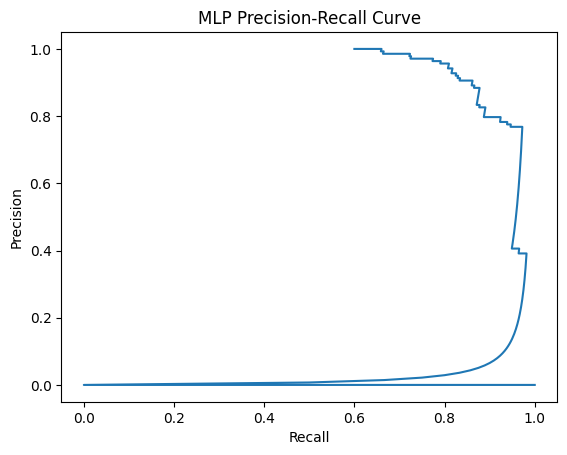

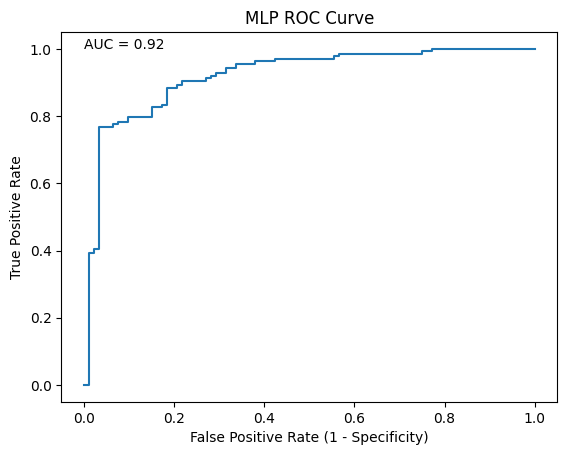

In [112]:
# Train MLP model on training data
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train, y_train)

# Use test data to determine model performance as confusion matrix and accuracy score
mlp_conf = confusion_matrix(y_test, mlp.predict(X_test))
mlp_acc = accuracy_score(y_test, mlp.predict(X_test))

# Print out results
print("MLP accuracy score = " + str(mlp_acc))
print("MLP train accuracy score = ", accuracy_score(y_train, mlp.predict(X_train)))
print(mlp_conf)

#plot Precision/Recall and ROC curves
plot_curves("MLP", mlp)

### visualize model performance

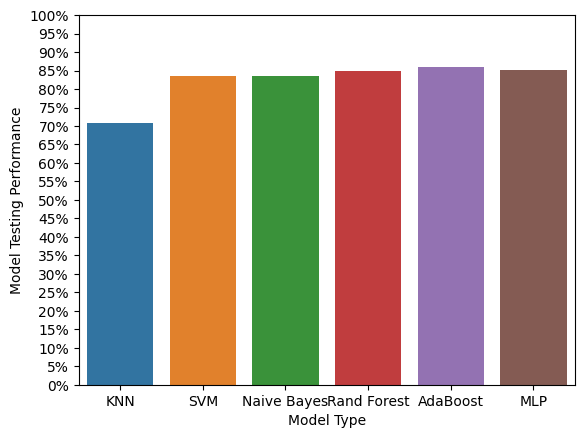

In [75]:
def compareModelPerformance(bars, performanceList, modelNames):
    performanceList = [x*100 for x in performanceList]
    ax = sns.barplot(x=np.arange(bars), y=performanceList)
    yticks = [x*5 for x in range(21)]
    ylabels = []
    for i in range(len(yticks)):
        ylabels.append(f"{yticks[i]}%")
    plt.yticks(yticks, ylabels)
    plt.xticks(range(bars), modelNames)
    plt.ylabel("Model Testing Performance")
    plt.xlabel("Model Type")
    plt.show()
compareModelPerformance(6, [best_knn_acc, svm_acc, gnb_acc, rf_acc, ab_acc, mlp_acc], ["KNN", "SVM", "Naive Bayes", "Rand Forest", "AdaBoost", "MLP"])

### Highest performing model with default hyperparameters: AdaBoost (default decision tree max_depth=1?)
- with default n_estimators 50, implies decision stumps <= 50 best classifier?
- 86.1% accuracy
### Second highest performing: MLP 
- 85.2% accuracy
### Perform hyperparameter search on MLP to optimize
- GridSearchCV
    - Evaluates performance with KFolds
    - Decrease number of folds for computational efficiency, but changes results
    - 10 folds used for search
- Start with neural architecture and initial learning rate

In [76]:
hidden_layer_sizes = [(100,), (100,100), (100,100,100), (200,), (200,100), (200,100,100), (500), (500,200), (500,200,100)]
learning_rate_init = [0.0001, 0.001, 0.01, 0.1, 1]
params = {
    "hidden_layer_sizes": hidden_layer_sizes,
    "learning_rate_init": learning_rate_init,
}

mlpOP = MLPClassifier(random_state=0)
grid = GridSearchCV(estimator=mlp, param_grid=params, n_jobs=-1, cv=10)
grid_result = grid.fit(X_train, y_train.ravel())
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.870610 using {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
0.824062 (0.063406) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0001}
0.870610 (0.037922) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
0.819544 (0.054592) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
0.838662 (0.041856) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.1}
0.521739 (0.031095) with: {'hidden_layer_sizes': (100,), 'learning_rate_init': 1}
0.809591 (0.067149) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.0001}
0.802344 (0.085976) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001}
0.825661 (0.059578) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01}
0.537809 (0.003154) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.1}
0.530563 (0.022481) with: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 1}
0.793500 (0.053965) with: {'hidden_layer_sizes': (1

- visualize

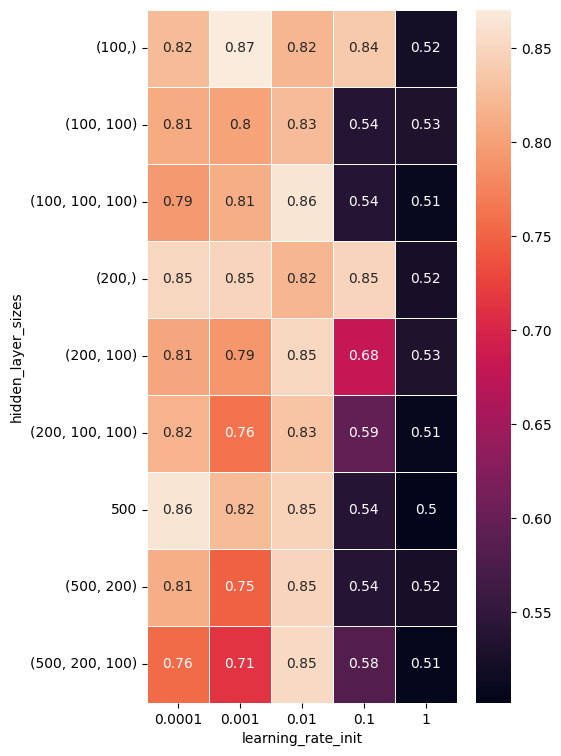

In [77]:
def modelPerformanceMatrix(means, param1, param2):
    #create matrix of performances, one coordinate represents one combination of hyperparameters

    paramMatrix = [[]]
    paramListIndex = 0
    matrixIndex = 0

    for i in range(1, len(means) + 1):
        paramMatrix[matrixIndex].append(means[i - 1])
        if((i % (len(param1["list"]))) == 0):
            matrixIndex += 1
            paramMatrix.append([])
    if(paramMatrix[len(paramMatrix) - 1] == []):
        paramMatrix.pop()
    f, ax = plt.subplots(figsize=(len(param1["list"]), len(param2["list"])))
    sns.heatmap(paramMatrix, annot=True,  linewidths=.5, ax=ax, xticklabels=param1["list"], yticklabels=param2["list"])

    plt.ylabel(param2["name"])
    plt.xlabel(param1["name"])
modelPerformanceMatrix(means, {"name": "learning_rate_init", "list": learning_rate_init}, {"name": "hidden_layer_sizes", "list": hidden_layer_sizes})

- Found (100,) and .001
- Follow up with activation function and learning rate

In [78]:
activation = ["tanh", "logistic", "identity", "relu"]
learning_rate = ["constant", "invscaling", "adaptive"]
params = {
    "activation": activation,
    "learning_rate": learning_rate,
    "learning_rate_init": [0.001],
    "hidden_layer_sizes": [(100,)]
}
mlpOP = MLPClassifier(random_state=0)
grid = GridSearchCV(estimator=mlp, param_grid=params, n_jobs=-1, cv=10)
grid_result = grid.fit(X_train, y_train.ravel())
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.870610 using {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
0.864727 (0.050916) with: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
0.864727 (0.050916) with: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001}
0.864727 (0.050916) with: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
0.870567 (0.051532) with: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
0.870567 (0.051532) with: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001}
0.870567 (0.051532) with: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
0.853090 (0.037539) with: {'ac

- visualize

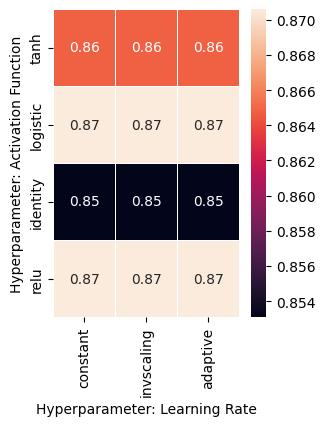

In [79]:
modelPerformanceMatrix(means, {"name": "Hyperparameter: Learning Rate", "list": learning_rate}, {"name": "Hyperparameter: Activation Function", "list": activation})

- found relu activation, constant learning rate

In [80]:
mlpOP = MLPClassifier(random_state=0, activation="relu", hidden_layer_sizes=(100,), learning_rate_init=.001, learning_rate="constant")
mlpOP.fit(X_train, y_train)
print("Optimal MLP Test Accuracy: ", accuracy_score(y_test, mlpOP.predict(X_test)))

Optimal MLP Test Accuracy:  0.8521739130434782


In [81]:
print("Optimal MLP Train Accuracy: ", accuracy_score(y_train, mlpOP.predict(X_train)))

Optimal MLP Train Accuracy:  0.8822674418604651


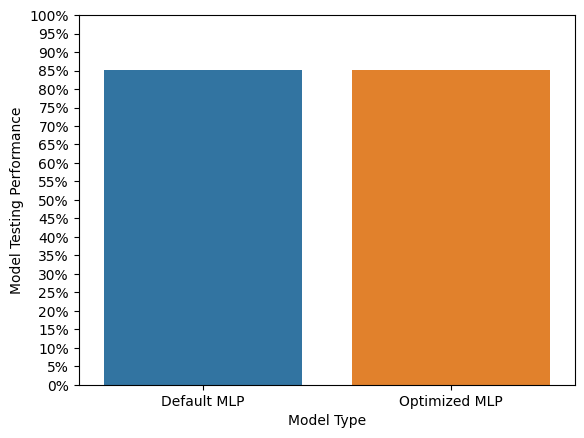

In [82]:
compareModelPerformance(2, [accuracy_score(y_test, mlp.predict(X_test)), accuracy_score(y_test, mlpOP.predict(X_test))], ["Default MLP", "Optimized MLP"])

### Hyperparameter search actually found default parameters to be optimal. Explore different base estimators for Adaboost?

### Logistic regression for probabilistic interpretation of data

In [83]:
lgr = LogisticRegression(random_state=0)
lgr.fit(X_train, y_train)
lgr_acc = accuracy_score(y_test, lgr.predict(X_test))
print(lgr_acc)
lgrProbs = lgr.predict_proba(X_train)
print(lgrProbs)
def modelFeatureRanking(model):
    model_perm_imp = permutation_importance(model, X, y, n_repeats=50, random_state=0)
    for i in model_perm_imp.importances_mean.argsort()[::-1]:
        print(feature_cols_clean[i] + ": " + str(model_perm_imp.importances_mean[i]))
    return model_perm_imp
lgr_perm_imp = modelFeatureRanking(lgr)

0.8217391304347826
[[0.99081033 0.00918967]
 [0.0325769  0.9674231 ]
 [0.17038822 0.82961178]
 ...
 [0.90611968 0.09388032]
 [0.06612193 0.93387807]
 [0.95082793 0.04917207]]
ST_Slope_Up: 0.03189542483660133
ST_Slope_Flat: 0.03089324618736387
Sex: 0.01840958605664491
ChestPainType_ASY: 0.018061002178649265
FastingBS: 0.015664488017429215
Cholesterol: 0.00960784313725493
Oldpeak: 0.009324618736383461
ChestPainType_ATA: 0.007908496732026166
ExerciseAngina_Y: 0.00383442265795209
ExerciseAngina_N: 0.0016557734204793294
ChestPainType_NAP: 0.0008278867102396892
MaxHR: 0.0007407407407407706
ChestPainType_TA: -0.00010893246187363426
RestingECG_LVH: -0.00013071895424833225
ST_Slope_Down: -0.00023965141612199313
RestingECG_Normal: -0.0005010893246187176
Age: -0.0006535947712418055
RestingECG_ST: -0.0013943355119825295
RestingBP: -0.0020697167755990976


### Show averages of values at each percentile in logistic regression
- entries in X_train to their nearest probability (0-100%, multiples of 5)

{0: [], 5: [], 10: [], 15: [], 20: [], 25: [], 30: [], 35: [], 40: [], 45: [], 50: [], 55: [], 60: [], 65: [], 70: [], 75: [], 80: [], 85: [], 90: [], 95: [], 100: []}
{0: [0, 8, 11, 24, 36, 37, 53, 61, 77, 103, 115, 137, 163, 168, 180, 183, 201, 215, 248, 251, 298, 299, 338, 356, 375, 381, 403, 416, 429, 437, 443, 456, 463, 475, 487, 496, 526, 534, 544, 578, 600, 611, 625, 629, 636, 642, 644, 679], 5: [15, 19, 30, 33, 40, 57, 62, 71, 84, 89, 97, 105, 106, 120, 121, 133, 139, 140, 153, 172, 176, 177, 182, 186, 191, 196, 197, 204, 208, 209, 213, 214, 216, 219, 225, 228, 230, 236, 240, 255, 257, 266, 267, 278, 281, 283, 287, 301, 302, 303, 305, 316, 325, 326, 330, 343, 345, 349, 351, 358, 362, 376, 377, 378, 395, 397, 399, 413, 414, 415, 431, 434, 444, 447, 459, 466, 476, 477, 492, 493, 498, 504, 507, 514, 525, 539, 542, 546, 549, 555, 563, 569, 571, 580, 582, 584, 587, 597, 614, 617, 618, 627, 634, 638, 641, 647, 648, 649, 657, 661, 684, 687], 10: [13, 23, 25, 70, 88, 100, 107, 112, 114

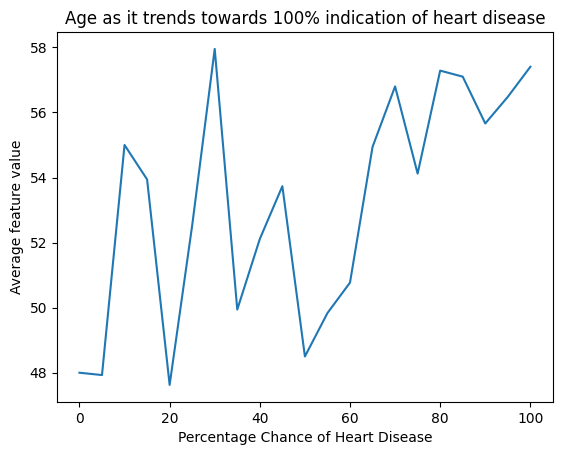

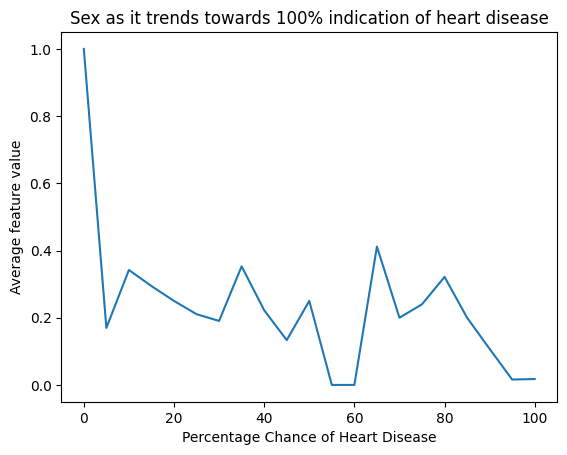

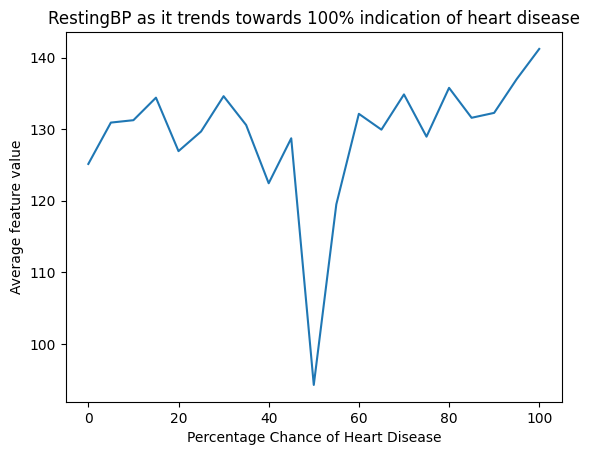

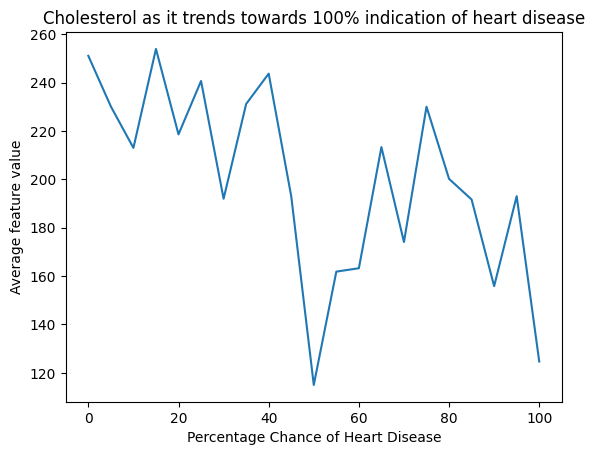

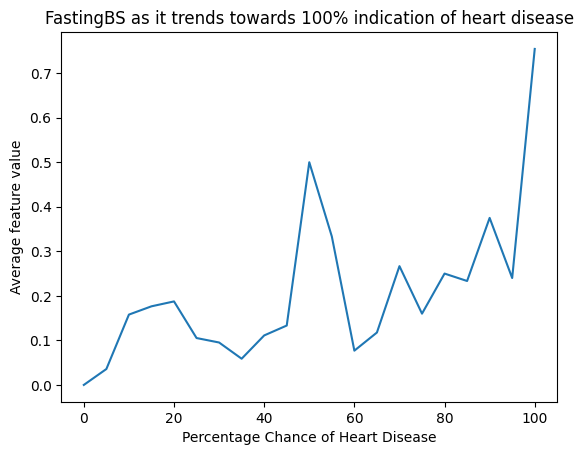

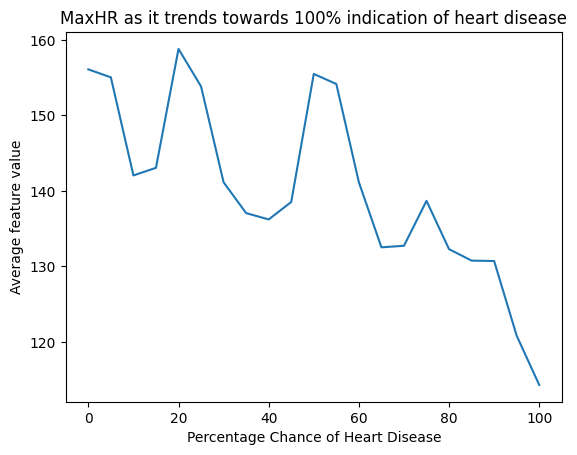

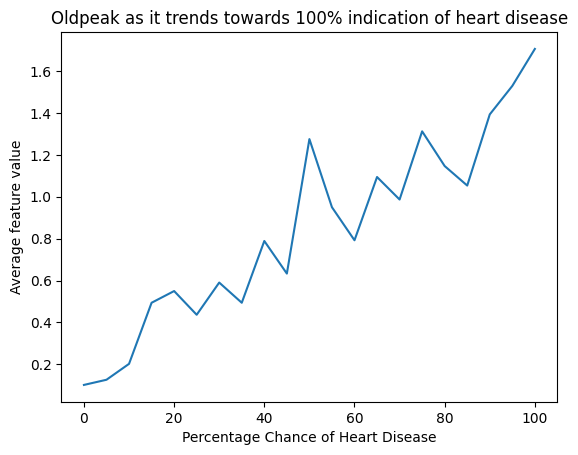

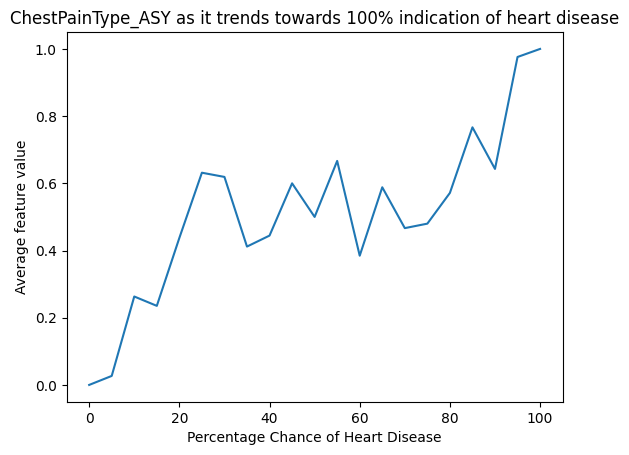

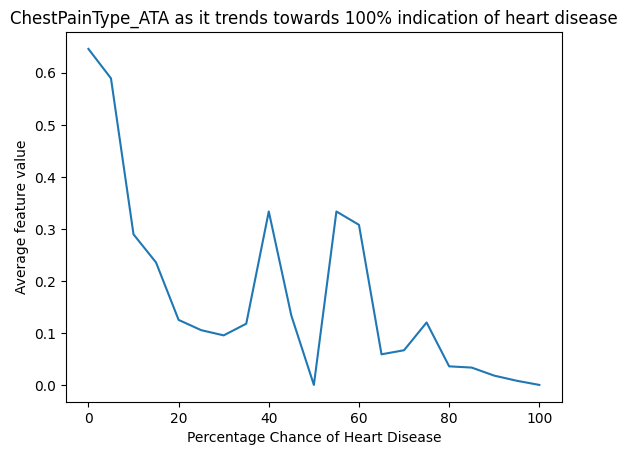

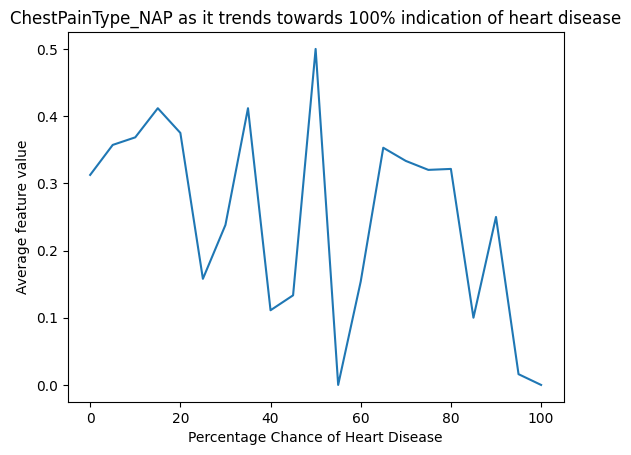

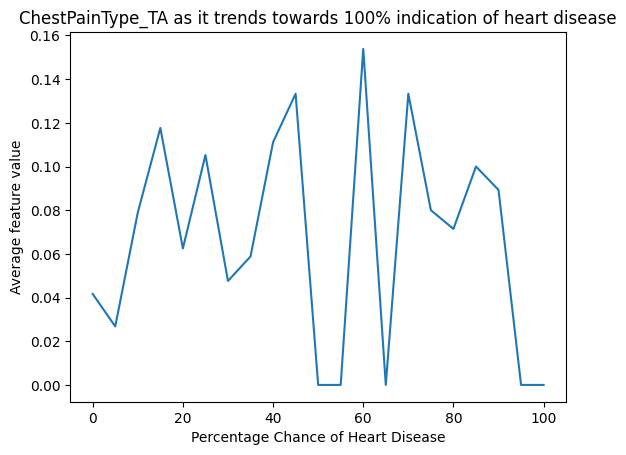

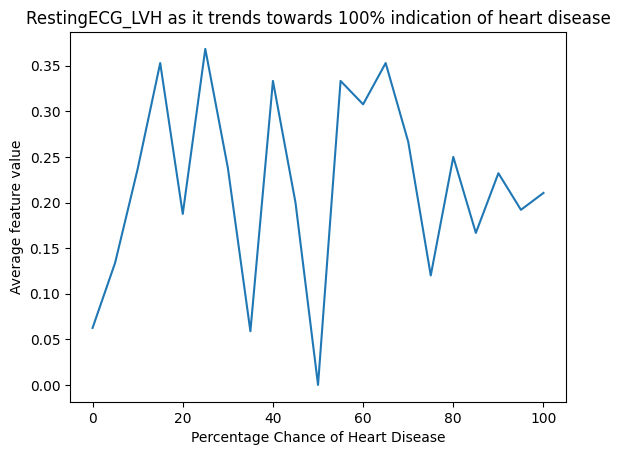

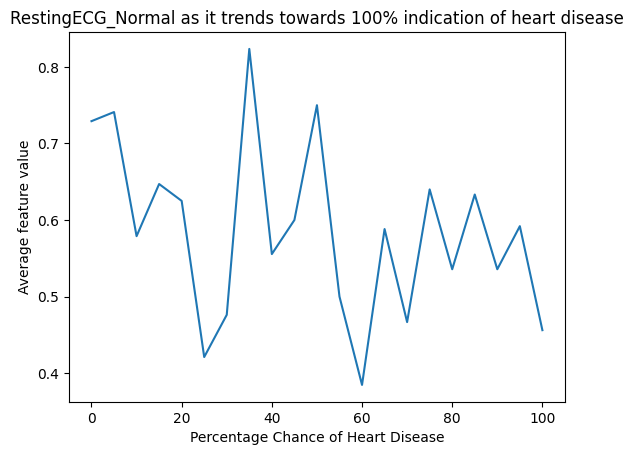

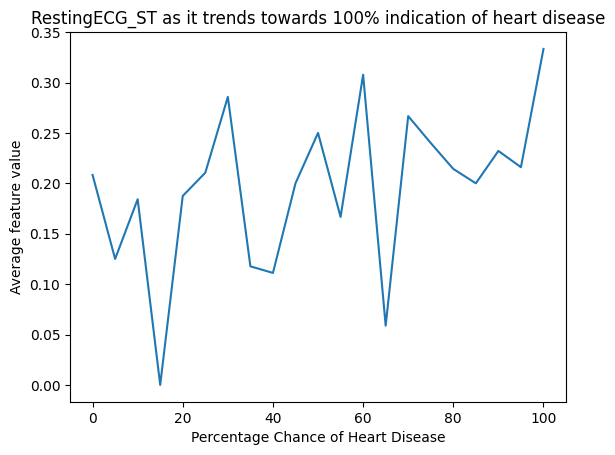

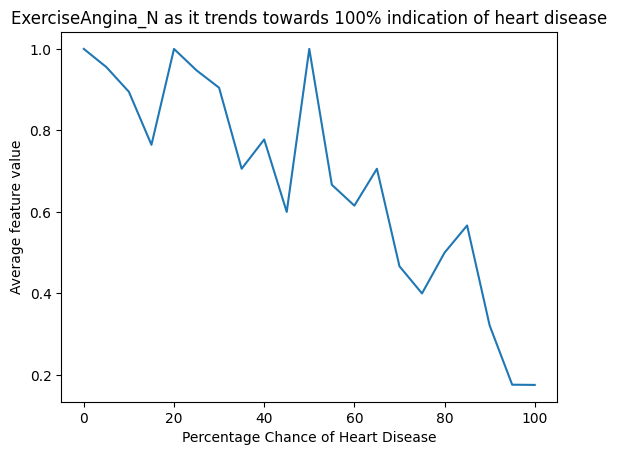

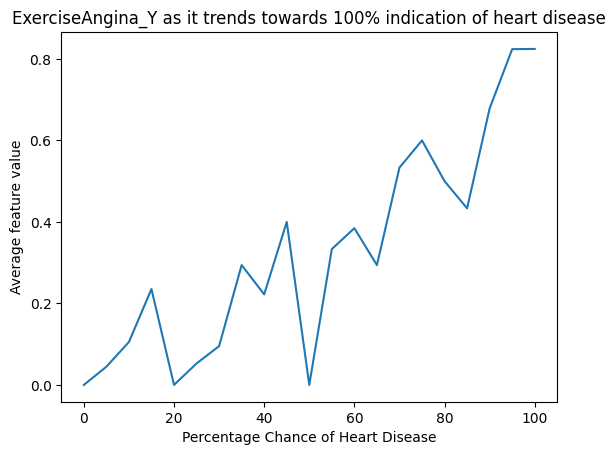

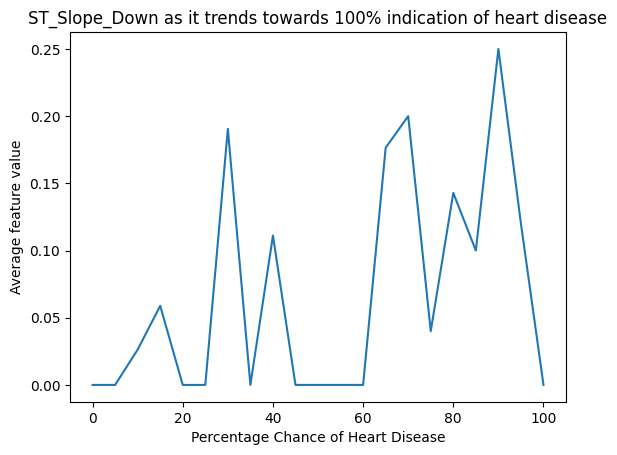

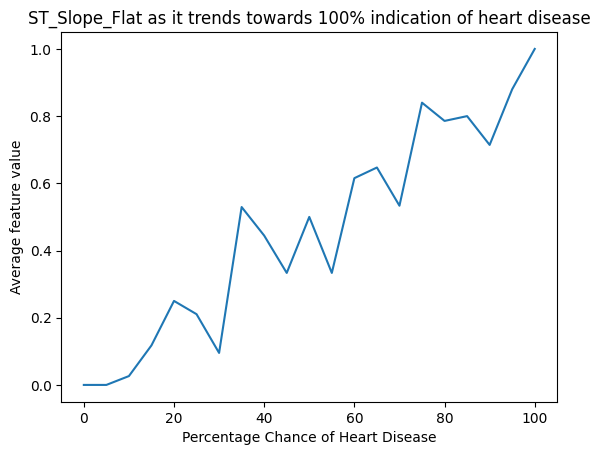

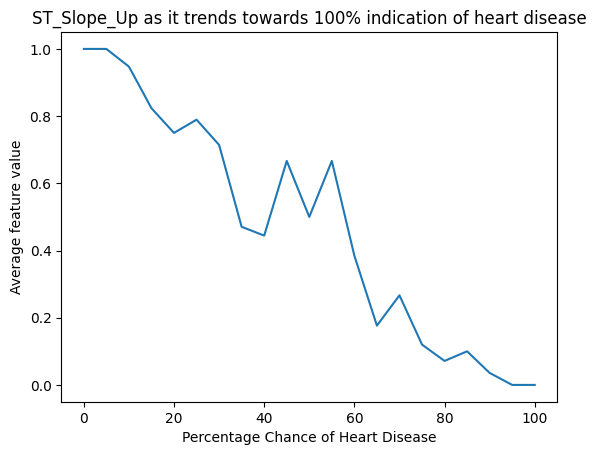

In [84]:
entryPercentiles = dict()
for i in range(0,100+1, 5):
    entryPercentiles.update({i: []})
print(entryPercentiles)
for i in range(len(lgrProbs)):
    entryPercentiles[floor(5 * round((100 * lgrProbs[i][1]) / 5))].append(i)
print(entryPercentiles)
print(len(X_train))
print(lgr.predict_proba([X_train[1]]))

def plotFeatureTrend(featureName, featureIndex):
    xAxis = []
    yAxis = []
    for i in range(0,101,5):
        if(len(entryPercentiles[i]) == 0):
            continue
        featureSum = 0
        for k in entryPercentiles[i]:
            featureSum += X_train[k][featureIndex]
        xAxis.append(i)
        yAxis.append(featureSum / len(entryPercentiles[i]))
    plt.plot(xAxis, yAxis)
    plt.xlabel("Percentage Chance of Heart Disease")
    plt.ylabel("Average feature value")
    plt.title(f'{featureName} as it trends towards 100% indication of heart disease')
    plt.show()
for i in range(len(feature_cols_clean)):
    plotFeatureTrend(feature_cols_clean[i], i)

Rank the features in order of importance using permutation feature importance for every ML model

KNN permutation feature importance (BEWARE: slow)

In [85]:
knn_perm_imp = permutation_importance(best_knn, X, y, n_repeats=50, random_state=0)

In [86]:
for i in knn_perm_imp.importances_mean.argsort()[::-1]:
    print(feature_cols_clean[i] + ": " + str(knn_perm_imp.importances_mean[i]))

MaxHR: 0.10938997821350759
Cholesterol: 0.07777777777777774
RestingBP: 0.01647058823529408
Age: 0.012461873638344185
Oldpeak: 0.0007189542483659773
ChestPainType_TA: 0.0
Sex: 0.0
FastingBS: 0.0
ChestPainType_NAP: 0.0
RestingECG_LVH: 0.0
RestingECG_Normal: 0.0
RestingECG_ST: 0.0
ExerciseAngina_N: 0.0
ExerciseAngina_Y: 0.0
ST_Slope_Down: 0.0
ChestPainType_ATA: -0.00028322440087147794
ST_Slope_Up: -0.00043572984749458145
ST_Slope_Flat: -0.0005664488017429559
ChestPainType_ASY: -0.0005664488017429559


SVM permutation feature importance

In [87]:
svm_perm_imp = permutation_importance(heart_svm, X, y, n_repeats=50, random_state=0)

In [88]:
for i in svm_perm_imp.importances_mean.argsort()[::-1]:
    print(feature_cols_clean[i] + ": " + str(svm_perm_imp.importances_mean[i]))

ST_Slope_Up: 0.025599128540304966
ST_Slope_Flat: 0.024945533769063135
Sex: 0.022440087145969456
FastingBS: 0.018126361655773384
ChestPainType_ASY: 0.00999999999999996
Oldpeak: 0.0062745098039215215
Cholesterol: 0.006078431372548978
ExerciseAngina_Y: 0.0042483660130718534
ExerciseAngina_N: 0.0042483660130718534
ChestPainType_ATA: 0.0008278867102396048
ST_Slope_Down: 0.0
RestingECG_ST: -2.178649237476904e-05
ChestPainType_TA: -0.00023965141612201536
RestingECG_Normal: -0.0003703703703703942
MaxHR: -0.0004793028322440462
Age: -0.0011764705882353322
RestingBP: -0.0015686274509804266
ChestPainType_NAP: -0.002461873638344261
RestingECG_LVH: -0.003050108932461899


Gaussian Naive Bayes permutation feature importance

In [89]:
gnb_perm_imp = permutation_importance(gnb, X, y, n_repeats=50, random_state=0)

In [90]:
for i in gnb_perm_imp.importances_mean.argsort()[::-1]:
    print(feature_cols_clean[i] + ": " + str(gnb_perm_imp.importances_mean[i]))

ST_Slope_Up: 0.02230936819172113
ST_Slope_Flat: 0.01668845315904141
ChestPainType_ATA: 0.016688453159041397
Oldpeak: 0.01607843137254903
Cholesterol: 0.013289760348583883
FastingBS: 0.012592592592592593
Sex: 0.011263616557734207
ChestPainType_ASY: 0.009302832244008716
ExerciseAngina_Y: 0.0054248366013071835
ExerciseAngina_N: 0.0054248366013071835
MaxHR: 0.0034640522875816915
ChestPainType_NAP: 0.0031590413943355044
RestingECG_ST: 0.0021132897603485822
ChestPainType_TA: 0.0013071895424836533
ST_Slope_Down: 0.0010675381263616512
RestingBP: 0.0010457516339869243
RestingECG_Normal: -0.00019607843137255275
Age: -0.0007843137254901889
RestingECG_LVH: -0.0026579520697167713


Random Forest permutation feature importance

In [91]:
rf_perm_imp = permutation_importance(rf, X, y, n_repeats=50, random_state=0)

In [92]:
for i in rf_perm_imp.importances_mean.argsort()[::-1]:
    print(feature_cols_clean[i] + ": " + str(rf_perm_imp.importances_mean[i]))

ST_Slope_Up: 0.06385620915032679
ChestPainType_ASY: 0.039760348583877995
Cholesterol: 0.037211328976034845
Oldpeak: 0.031612200435729834
MaxHR: 0.03137254901960783
Sex: 0.025816993464052276
Age: 0.023246187363834415
RestingBP: 0.02030501089324618
FastingBS: 0.01206971677559911
ExerciseAngina_Y: 0.009019607843137243
ExerciseAngina_N: 0.00836601307189541
ST_Slope_Flat: 0.00723311546840957
ChestPainType_NAP: 0.006318082788671003
ChestPainType_ATA: 0.0056427015250544495
RestingECG_ST: 0.005272331154684082
RestingECG_LVH: 0.00511982570806099
RestingECG_Normal: 0.0036601307189542374
ST_Slope_Down: 0.00013071895424836112
ChestPainType_TA: 0.0


AdaBoost permutation feature importance

In [93]:
ab_perm_imp = permutation_importance(ab, X, y, n_repeats=50, random_state=0)

In [94]:
for i in ab_perm_imp.importances_mean.argsort()[::-1]:
    print(feature_cols_clean[i] + ": " + str(ab_perm_imp.importances_mean[i]))

ST_Slope_Up: 0.12074074074074073
ChestPainType_ASY: 0.03570806100217861
Oldpeak: 0.022875816993464016
Sex: 0.02045751633986924
Cholesterol: 0.018758169934640478
FastingBS: 0.016274509803921533
MaxHR: 0.015795206971677515
RestingBP: 0.011481481481481443
ExerciseAngina_Y: 0.007211328976034832
Age: 0.006906318082788643
ST_Slope_Down: 0.0031372549019607486
RestingECG_Normal: 0.0029411764705881984
ChestPainType_ATA: 0.002483660130718921
ST_Slope_Flat: 0.0
RestingECG_ST: 0.0
ExerciseAngina_N: 0.0
ChestPainType_NAP: 0.0
ChestPainType_TA: -0.0007843137254902311
RestingECG_LVH: -0.0032244008714597205


MLP permutation feature importance

In [95]:
mlp_perm_imp = permutation_importance(mlpOP, X, y, n_repeats=50, random_state=0)

In [96]:
for i in mlp_perm_imp.importances_mean.argsort()[::-1]:
    print(feature_cols_clean[i] + ": " + str(mlp_perm_imp.importances_mean[i]))

Cholesterol: 0.047625272331154725
ST_Slope_Flat: 0.021111111111111146
MaxHR: 0.01954248366013075
Oldpeak: 0.017952069716775633
Sex: 0.01644880174291943
ST_Slope_Up: 0.01618736383442269
ExerciseAngina_Y: 0.01017429193899785
ChestPainType_ASY: 0.009629629629629662
ChestPainType_ATA: 0.008845315904139466
RestingBP: 0.008148148148148187
ChestPainType_NAP: 0.005795206971677602
ExerciseAngina_N: 0.004901960784313761
Age: 0.004553376906318123
FastingBS: 0.0023093681917211706
RestingECG_ST: 0.0012854030501089709
RestingECG_Normal: 0.0006753812636165924
ChestPainType_TA: 0.00019607843137257498
ST_Slope_Down: -0.0003050108932461582
RestingECG_LVH: -0.000980392156862706


Find overall feature importance rankings using weighted average of models' permutation importance values

In [97]:
models_perm_imps = (knn_perm_imp, svm_perm_imp, gnb_perm_imp, rf_perm_imp, ab_perm_imp, mlp_perm_imp, lgr_perm_imp)

models_accs = (best_knn_acc, svm_acc, gnb_acc, rf_acc, ab_acc, mlp_acc, lgr_acc)

# Init dictionary of weighted feature importance values keyed on feature name all to 0
feature_importances = {}
for feature in feature_cols_clean:
    feature_importances[feature] = 0

# Caclulate mean importance value for every feature for every ML model
i = 0
for cur_perm_imp in models_perm_imps:
    for j in range(cur_perm_imp.importances_mean.size):
        feature_importances[feature_cols_clean[j]] += cur_perm_imp.importances_mean[j] * models_accs[i]
    i += 1

sum_accs = sum(models_accs)
for feature in feature_cols_clean:
    feature_importances[feature] /= sum_accs

# Sort the dictionary of features by mean importance value
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# Print out dictionary of features sorted by mean importance value
i = 1
for key, value in feature_importances.items():
    print(str(i) + ". " + key + " = " + str(value))
    i +=1

1. ST_Slope_Up = 0.04127320261437907
2. Cholesterol = 0.029069609898466714
3. MaxHR = 0.02386344391005877
4. ChestPainType_ASY = 0.017915632835943593
5. Sex = 0.016799539606198868
6. Oldpeak = 0.015383927323549955
7. ST_Slope_Flat = 0.014557323138899163
8. FastingBS = 0.01123563119168002
9. RestingBP = 0.007564516792041757
10. Age = 0.0062824187117194825
11. ChestPainType_ATA = 0.006141472438031809
12. ExerciseAngina_Y = 0.005858708430961477
13. ExerciseAngina_N = 0.003594228634850166
14. ChestPainType_NAP = 0.0020061988736794533
15. RestingECG_ST = 0.0010702511612611534
16. RestingECG_Normal = 0.0009245200805689117
17. ST_Slope_Down = 0.000563439799399843
18. ChestPainType_TA = 5.0955728203227565e-05
19. RestingECG_LVH = -0.0007191515599950651


Plot overall feature importance rankings using weighted average of models' permutation importance values

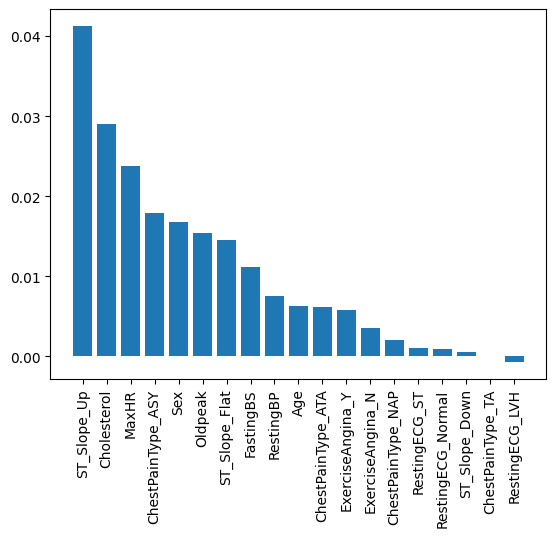

In [98]:
plt.bar(feature_importances.keys(), feature_importances.values())
plt.xticks(rotation = 90)
plt.show()

### Table of feature rankings by model

[['Age', 0.012461873638344185, -0.0011764705882353322, -0.0007843137254901889, 0.023246187363834415, 0.006906318082788643, 0.004553376906318123, -0.0006535947712418055], ['Sex', 0.0, 0.022440087145969456, 0.011263616557734207, 0.025816993464052276, 0.02045751633986924, 0.01644880174291943, 0.01840958605664491], ['RestingBP', 0.01647058823529408, -0.0015686274509804266, 0.0010457516339869243, 0.02030501089324618, 0.011481481481481443, 0.008148148148148187, -0.0020697167755990976], ['Cholesterol', 0.07777777777777774, 0.006078431372548978, 0.013289760348583883, 0.037211328976034845, 0.018758169934640478, 0.047625272331154725, 0.00960784313725493], ['FastingBS', 0.0, 0.018126361655773384, 0.012592592592592593, 0.01206971677559911, 0.016274509803921533, 0.0023093681917211706, 0.015664488017429215], ['MaxHR', 0.10938997821350759, -0.0004793028322440462, 0.0034640522875816915, 0.03137254901960783, 0.015795206971677515, 0.01954248366013075, 0.0007407407407407706], ['Oldpeak', 0.00071895424836

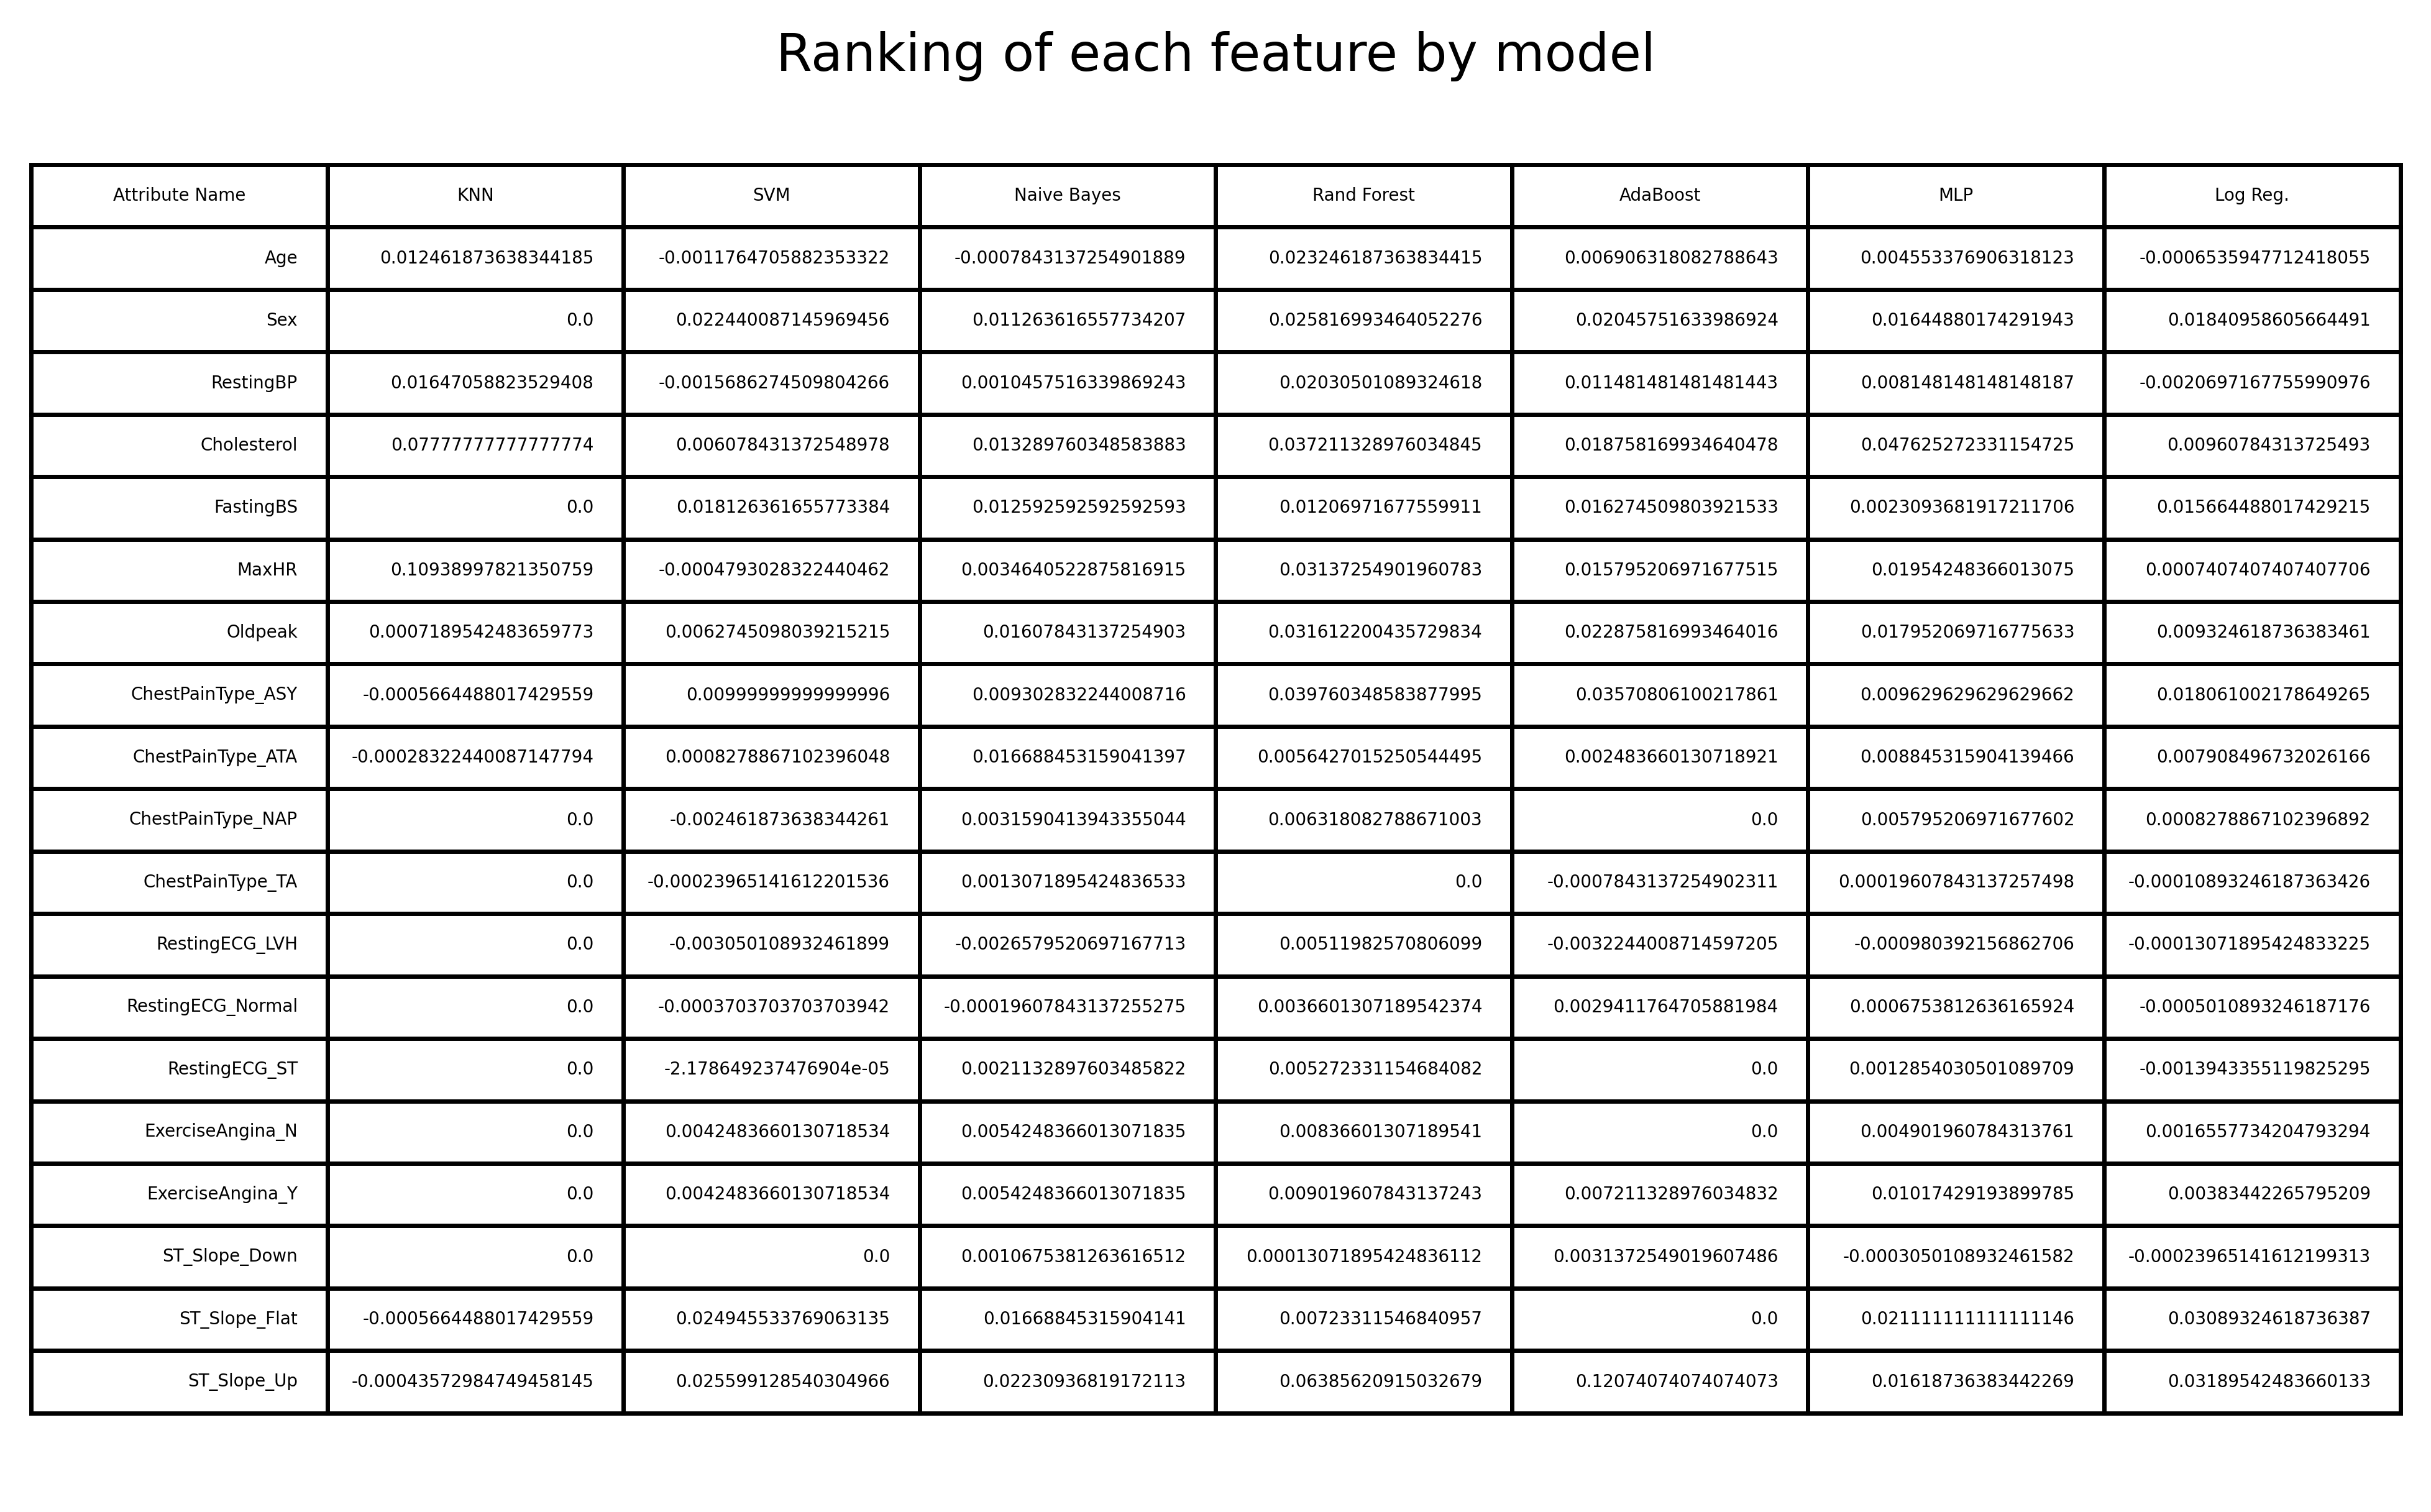

In [99]:
rankTable = []
for i in range(len(feature_cols_clean)):
    rankRow = [feature_cols_clean[i]]
    for model in models_perm_imps:
        rankRow.append(model.importances_mean[i])
    rankTable.append(rankRow)

print(rankTable)
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame(rankTable, columns=['Attribute Name', 'KNN', 'SVM', 'Naive Bayes', 'Rand Forest', 'AdaBoost', 'MLP', 'Log Reg.'])
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
plt.title("Ranking of each feature by model")
fig.tight_layout()
fig.set_dpi(500)
table.set_fontsize(8)
fig.set_size_inches(8,5)
plt.show()